<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check pytorch version
import torch
print(torch.__version__)

2.2.1+cu121


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lift model

模型架構圖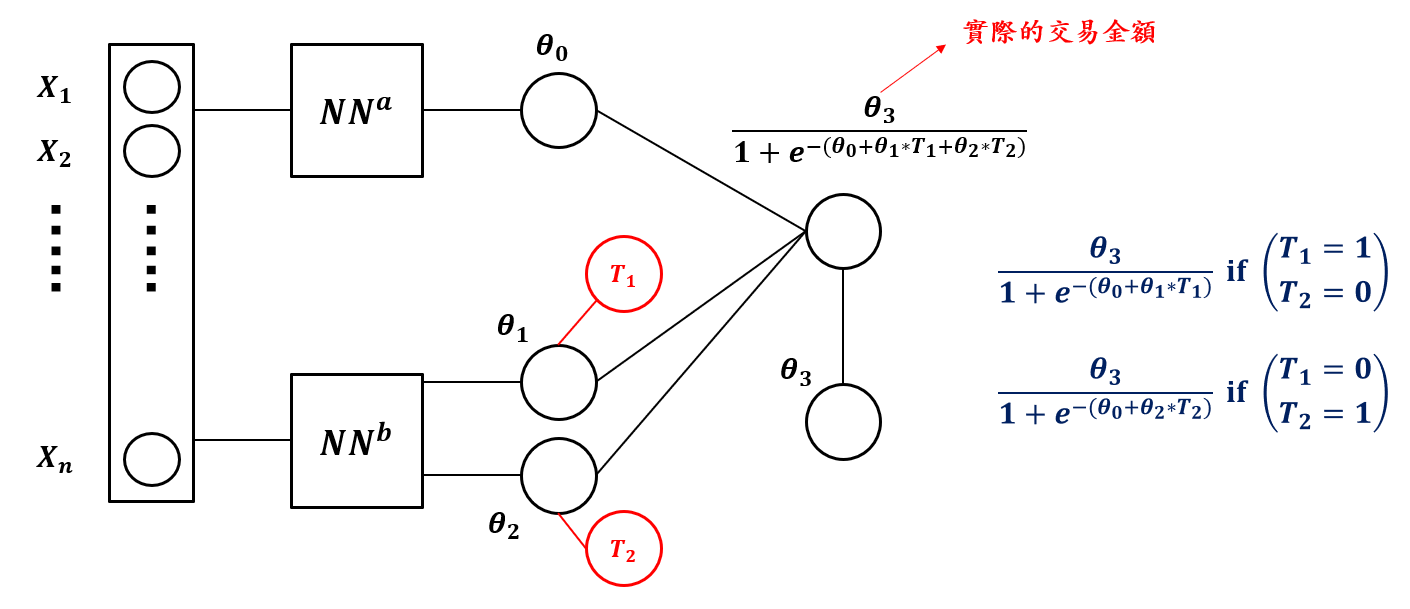

In [2]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202401.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202401.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F2593340910,18,0,2.0,0,120.0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,F2593358270,19,0,2.0,0,0.0,1,2,0,3,...,0,0,0,0,0,1,0,0,0,0
2,F2593378680,19,0,2.0,0,50.0,1,0,0,6,...,0,0,0,0,0,1,0,0,0,0
3,F2593397620,19,0,2.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
4,F2598703540,17,0,2.0,0,0.0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092946,Z1222305990,50,0,1.0,0,600.0,1,3,0,1,...,0,0,0,1,0,0,0,1,0,1
1092947,Y2729592620,60,0,2.0,0,0.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
1092948,Z1222367980,47,0,1.0,0,420.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1092949,Z1222472300,30,0,1.0,0,550.0,1,1,0,1,...,0,0,1,0,0,1,0,0,0,0


In [ ]:
df.select_dtypes(include=['object']).columns

Index(['UNINO'], dtype='object')

In [4]:
binary_columns = []

for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) <= 2 and (0 in unique_values or 1 in unique_values):
        binary_columns.append(column)

print("Columns with binary values:")
print(binary_columns)
print(len(binary_columns)) #69

# Convert columns to object data type
df[binary_columns] = df[binary_columns].astype('int64')

Columns with binary values:
['公司戶記號', '呆帳記號_含信用卡', '網路會員記號', '網路使用記號', '薪轉戶記號', '銀行靜止戶記號', '停滯戶記號', '催收記號_不含信用卡', '上市櫃公司員工記號', '存款記號', '信貸記號', '房貸記號', '員工記號', '金控員工記號_非銀行', '證券推介開戶記號', '數位帳戶等級記號', '換匯發送名單', '跨售行為', '近三個月是否發送過外匯名單', '近三個月是否發送過其他名單', '中小企業記號_0', '客戶行業別_住宿及餐飲業', '客戶行業別_保全業', '客戶行業別_保險業', '客戶行業別_公職人員', '客戶行業別_其他', '客戶行業別_典當業', '客戶行業別_各級學校/學術機構', '客戶行業別_外交人員', '客戶行業別_大眾傳播', '客戶行業別_學生', '客戶行業別_家管', '客戶行業別_專業人士', '客戶行業別_廣告業', '客戶行業別_建築業', '客戶行業別_批發及零售業', '客戶行業別_技術服務業', '客戶行業別_投信／投顧／證券', '客戶行業別_政府機構', '客戶行業別_政治人物／演藝人員', '客戶行業別_旅遊業', '客戶行業別_水電燃氣業', '客戶行業別_演藝人員', '客戶行業別_無業', '客戶行業別_營造業', '客戶行業別_礦石及土石採取業', '客戶行業別_社工/義工', '客戶行業別_網路拍賣', '客戶行業別_自由業', '客戶行業別_藝品或寶石交易', '客戶行業別_虛擬貨幣業', '客戶行業別_製造業', '客戶行業別_貿易買賣業', '客戶行業別_資訊業', '客戶行業別_賭博／夜總會相關行業', '客戶行業別_軍官/軍人', '客戶行業別_軍警機構', '客戶行業別_農林漁牧業', '客戶行業別_運輸或倉儲及通訊業', '客戶行業別_醫療保健', '客戶行業別_金融業', '客戶行業別_電子業', '對帳單寄送記號_0', '對帳單寄送記號_1', '對帳單寄送記號_2', '信用卡VIP客戶註記_Y', '外幣存款記號_Y', '信用卡轉呆記號_Y', '信用卡自動扣款記號_Y']
69


In [63]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [64]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = list(numeric_cols)+(num_cols)
#numeric_cols.append(num_cols)
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
unino = test['UNINO']
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(874360, 204) (218591, 204)


In [ ]:
#Normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns #139

# Initialize StandardScaler
scaler = StandardScaler()
# Fit scaler on the entire numeric data
scaler.fit(df[numeric_cols])
df[numeric_cols].append(df[num_cols])
# Transform the entire numeric data
df[numeric_cols] = scaler.transform(df[numeric_cols])

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Drop the 'UNINO' column from both train and test sets
train.drop(['UNINO'], axis=1, inplace=True)
unino = test['UNINO']
test.drop(['UNINO'], axis=1, inplace=True)

print(train.shape, test.shape)

(174872, 204) (43718, 204)


In [22]:
df[numeric_cols]

,性別,客戶年收入,融資年交易額,融資三月交易額,融資六月交易額,融資庫存市值,融資使用金額,融券庫存市值,融券使用金額,信用卡最近一個月收單手續費收入,...,基金近12個月申購次數,最近一個月刷卡筆數,最近三個月刷卡筆數,最近六個月刷卡筆數,共同行銷合作推廣_證券,證券月交易筆數,證券近一年交易筆數,證券庫存股檔數,TOTALNTAMOUNT,外匯交易金額_近三個月
0,1.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.777778,0.0,0.000000,0.000000,0.0,0.0
2,1.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.111111,0.0,0.000000,0.000000,0.0,0.0
4,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.000000,0.0,0.000002,0.000225,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092946,0.5,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.343032,0.143293,0.101068,0.111111,0.0,0.000000,0.000000,0.0,0.0
1092947,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.326187,0.132927,0.090386,0.111111,0.0,0.000000,0.000000,0.0,0.0
1092948,0.5,0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.111111,0.0,0.000000,0.000000,0.0,0.0
1092949,0.5,0.000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299331,...,0.0,0.324655,0.129268,0.087921,0.111111,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
train.iloc[:,150]

42035     0
52145     0
142046    0
211846    0
191445    0
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: TOTALNTAMOUNT, Length: 174872, dtype: int64

In [38]:
import torch
import torch.nn as nn

class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Branch 1
        self.fc1_branch1 = nn.Linear(input_size, 128)
        self.relu1_branch1 = nn.ReLU()
        self.fc2_branch1 = nn.Linear(128, 1)

        # Branch 2
        self.fc1_branch2 = nn.Linear(input_size, 128)
        self.relu1_branch2 = nn.ReLU()
        self.fc2_branch2 = nn.Linear(128, 2)

        # Hidden layer
        self.fc_hidden = nn.Linear(3, 64)

        # Output layer
        self.fc_output = nn.Linear(64, 1)

    def forward(self, x):
        # Branch 1
        x_branch1 = self.relu1_branch1(self.fc1_branch1(x))
        x_branch1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = self.relu1_branch2(self.fc1_branch2(x))
        T1 = x[:, 149].unsqueeze(1)
        T2 = 1 - T1
        x_branch2 = torch.sigmoid(x_branch2)  # Apply sigmoid activation before element-wise multiplication
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2

        # Concatenate both branches
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Hidden layer
        x_hidden = torch.sigmoid(self.fc_hidden(x_concat))

        # Output layer
        output = torch.sigmoid(self.fc_output(x_hidden))
        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_hidden): Linear(in_features=3, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Check if GPU is available and move model to GPU
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# If you have labels (target variable) in your DataFrame, you can separate them
# For example, if the last column is the target variable
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_tensor = torch.tensor(train['跨售行為'].values)  # Last column as the target variable

# Define the model
input_size = 202 # Number of input features including T1
model = CustomNet(input_size)

# Define the loss function #Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000  # Number of epochs
desired_loss = 0.001  # Desired loss threshold

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor.float())  # Convert T1_train to float

    # Compute loss
    loss = criterion(outputs.squeeze(), y_tensor.float())  # Ensure y_tensor is of float type

    # Zero gradients, backward pass, and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

Epoch [1/10000], Loss: 0.8013
Epoch [2/10000], Loss: 0.7479
Epoch [3/10000], Loss: 0.6994
Epoch [4/10000], Loss: 0.6552
Epoch [5/10000], Loss: 0.6151
Epoch [6/10000], Loss: 0.5787
Epoch [7/10000], Loss: 0.5454
Epoch [8/10000], Loss: 0.5150
Epoch [9/10000], Loss: 0.4871
Epoch [10/10000], Loss: 0.4616
Epoch [11/10000], Loss: 0.4380
Epoch [12/10000], Loss: 0.4163
Epoch [13/10000], Loss: 0.3962
Epoch [14/10000], Loss: 0.3773
Epoch [15/10000], Loss: 0.3579
Epoch [16/10000], Loss: 0.3420
Epoch [17/10000], Loss: 0.3273
Epoch [18/10000], Loss: 0.3136
Epoch [19/10000], Loss: 0.3008
Epoch [20/10000], Loss: 0.2889


KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/NN_202401.pth')

In [39]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_202401.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_hidden): Linear(in_features=3, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=1, bias=True)
)

In [69]:
test.iloc[:,149] = 1

In [70]:
# Validation
# Assuming you have your test input data X_test in a tensor
test_data = torch.tensor(test.values, dtype=torch.float32)

X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['跨售行為'].values)  # Last column as the target variable

criterion = nn.BCELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

Predictions: [[0.0091612 ]
 [0.0089101 ]
 [0.00922063]
 ...
 [0.00918888]
 [0.00909576]
 [0.00924565]]
Test Loss: 0.020695306360721588


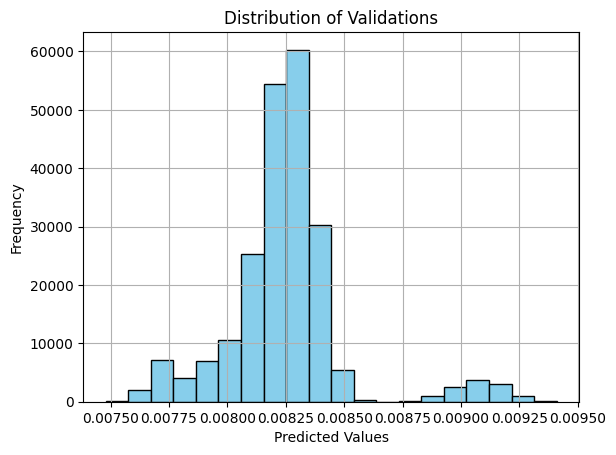

In [27]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Validations')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [65]:
val = pd.DataFrame(unino)
val = pd.concat([val, test[['換匯發送名單', '換匯基因標籤', '跨售行為', 'TOTALNTAMOUNT']]], axis = 1)
val.reset_index(drop=True, inplace=True)
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT
0,A2742220970,0,0.764158,0,0.0
1,K2723921770,0,0.727208,0,0.0
2,D1772966320,0,0.608271,0,0.0
3,H2755330340,0,0.884345,0,0.0
4,F2729554110,0,0.653208,0,0.0
...,...,...,...,...,...
218586,U2729454260,0,0.653207,0,0.0
218587,H1774062050,0,0.523841,0,0.0
218588,F2716006190,0,0.793448,0,0.0
218589,M2777104380,0,0.789480,0,0.0


In [71]:
#val['Lift_NN|T = 0'] = predictions_np
val['Lift_NN|T = 1'] = predictions_np
val['Lift_NN'] = val['Lift_NN|T = 1'] - val['Lift_NN|T = 0']
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN
0,A2742220970,0,0.764158,0,0.0,0.008305,0.009161,0.000857
1,K2723921770,0,0.727208,0,0.0,0.008101,0.008910,0.000809
2,D1772966320,0,0.608271,0,0.0,0.008340,0.009221,0.000881
3,H2755330340,0,0.884345,0,0.0,0.008292,0.009141,0.000848
4,F2729554110,0,0.653208,0,0.0,0.008216,0.009066,0.000849
...,...,...,...,...,...,...,...,...
218586,U2729454260,0,0.653207,0,0.0,0.007545,0.008293,0.000748
218587,H1774062050,0,0.523841,0,0.0,0.007915,0.008725,0.000811
218588,F2716006190,0,0.793448,0,0.0,0.008318,0.009189,0.000871
218589,M2777104380,0,0.789480,0,0.0,0.008268,0.009096,0.000828


In [72]:
val.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202404_results.csv')

In [28]:
!pip install scikit-uplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install plotly

In [29]:
import numpy as np
import pandas as pd
#import causalml
import random

%matplotlib inline
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift

In [73]:
from sklift.metrics import uplift_by_percentile
val['跨售行為'] = [0 if x == -1 else x for x in val['跨售行為']]
uplift_by_perc_df =  uplift_by_percentile(
    val["跨售行為"],
    val["Lift_NN"],
    val["換匯發送名單"],
    strategy="overall",
    total=False,
    std=True,
    bins=10
)

uplift_by_perc_df

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1018,20842,0.003929,0.000816,0.003114,0.001961,0.000198,0.001971
10-20,896,20963,0.004464,0.001526,0.002938,0.002227,0.000270,0.002243
20-30,1009,20850,0.007929,0.001391,0.006538,0.002792,0.000258,0.002804
30-40,1064,20795,0.009398,0.001491,0.007908,0.002958,0.000268,0.002970
40-50,1150,20709,0.006087,0.002221,0.003866,0.002294,0.000327,0.002317
50-60,1184,20675,0.010980,0.002563,0.008416,0.003028,0.000352,0.003049
60-70,1198,20661,0.013356,0.002178,0.011178,0.003317,0.000324,0.003332
70-80,1440,20419,0.014583,0.003575,0.011008,0.003159,0.000418,0.003187
80-90,1514,20345,0.013210,0.002998,0.010212,0.002934,0.000383,0.002959


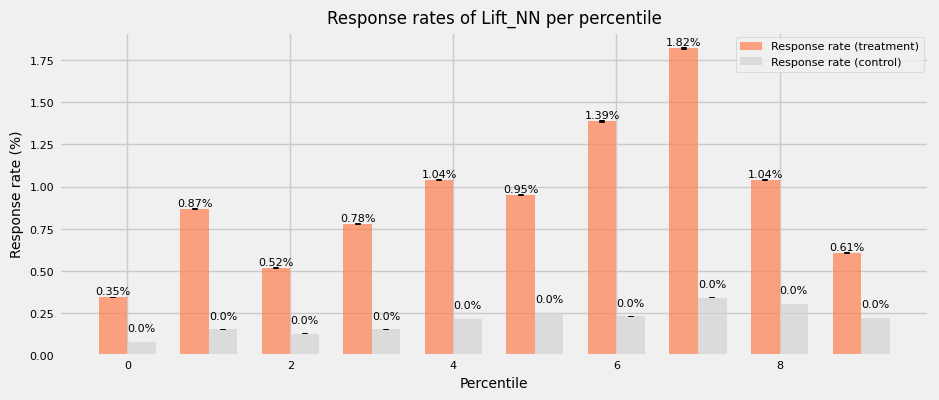

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklift.metrics import uplift_by_percentile

def plot_uplift_by_percentile(df, metric_column, bins=10):
    df['跨售行為'] = [0 if x == -1 else x for x in df['跨售行為']]

    # Fill NaN values in the metric_column with a specific value (e.g., 0)
    df[metric_column].fillna(0, inplace=True)

    uplift_by_perc_df = uplift_by_percentile(
        df["跨售行為"],
        df[metric_column],
        df["換匯發送名單"],
        strategy="by_group",
        total=False,
        std=True,
        bins=bins
    )

    fig, ax2 = plt.subplots(1, 1, figsize=(10, 4))
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    '''
    # Plot the first graph (Uplift)
    bars1 = ax1.bar(
        uplift_by_perc_df.index,
        uplift_by_perc_df.uplift,
        yerr=uplift_by_perc_df.std_uplift * 2,
        color='coral',
        alpha=0.7
    )

    ax1.set_title(f'Uplift of {metric_column} per percentile', fontsize=12)
    ax1.set_ylabel('Uplift (%)', fontsize=10)

    # Adding smaller text labels on each bar for Uplift
    for bar, label in zip(bars1, uplift_by_perc_df.uplift):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label * 100)}%', ha='center', va='bottom', fontsize=8)
        else:
            ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)'''

    # Plot the second graph (Response Rates for Treatment and Control)
    bar_width = 0.35
    index = np.arange(len(uplift_by_perc_df.index))

    bars2_treatment = ax2.bar(
        index - bar_width/2,
        uplift_by_perc_df.response_rate_treatment * 100,
        bar_width,
        label="Response rate (treatment)",
        color='coral',
        yerr=uplift_by_perc_df.std_treatment * 2,
        alpha=0.7
    )

    bars2_control = ax2.bar(
        index + bar_width/2,
        uplift_by_perc_df.response_rate_control * 100,
        bar_width,
        label="Response rate (control)",
        color='lightgrey',
        yerr=uplift_by_perc_df.std_control * 2,
        alpha=0.7
    )

    ax2.set_title(f'Response rates of {metric_column} per percentile', fontsize=12)
    ax2.set_xlabel('Percentile', fontsize=10)
    ax2.set_ylabel('Response rate (%)', fontsize=10)
    ax2.legend(fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Treatment)
    for bar, label in zip(bars2_treatment, uplift_by_perc_df.response_rate_treatment * 100):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, f'{round(label,2)}%', ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.006, 'NaN', ha='center', va='bottom', fontsize=8)
    # Adding smaller text labels on each bar for Response Rates (Control)
    for bar, label in zip(bars2_control, uplift_by_perc_df.response_rate_control ):
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{round(label,2)}%', ha='center', va='bottom', fontsize=8)

    # Set smaller font size for tick labels
    ax2.tick_params(axis='both', which='major', labelsize=8)

    # Ensure that the y-axis starts from 0
    ax2.set_ylim(bottom=0)

    plt.show()

# Usage example for 'Uplift_mean' column
plot_uplift_by_percentile(val, 'Lift_NN')

In [76]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.0 MB/s eta 0:00:00
  Using cached Cython-0.29.34-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  U

In [77]:
from causalml.metrics import plot_gain, get_cumgain
T = val
T =T[['換匯發送名單', '跨售行為',	'Lift_NN']]
cumgain = get_cumgain(T, outcome_col='跨售行為', treatment_col='換匯發送名單', normalize=True, random_seed=42)
cumgain

,Lift_NN,Random
0,0.000000,0.000000
1,0.000000,-0.000001
2,0.000000,-0.000005
3,0.000000,-0.000010
4,0.000000,-0.000018
...,...,...
218587,0.999976,0.999987
218588,0.999982,0.999993
218589,0.999988,0.999999
218590,0.999994,0.999994


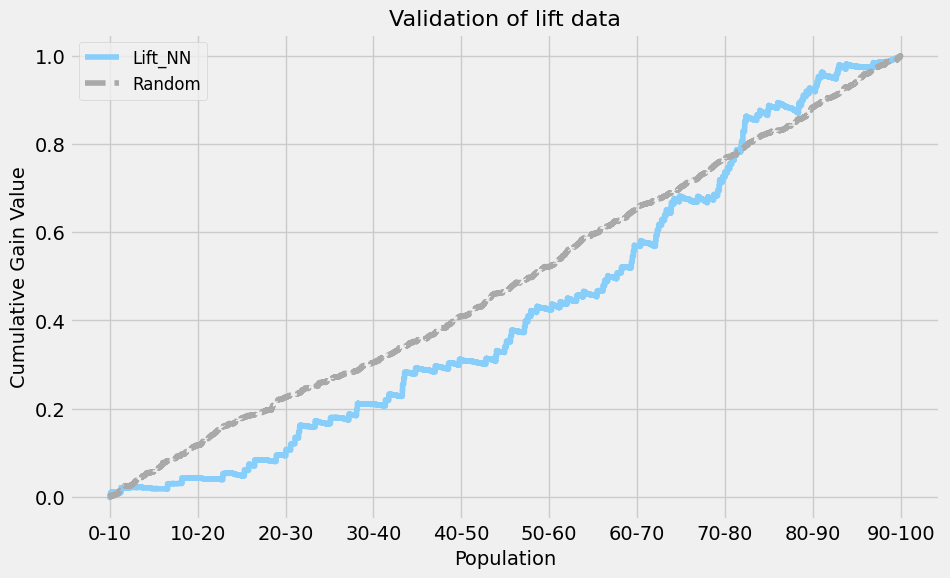

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have already imported pandas as pd and have the necessary dataframes

#df = pd.concat([cumgain, cumgain_1['Gi']], axis=1)
df = cumgain
#df = cumgain[:len(cumgain)//10]
x = df.index

# Define the ranges for the x-axis labels
#ranges = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
ranges = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Resample x to have 11 evenly spaced points
x_resampled = np.linspace(0, len(x) - 1, 10, dtype=int)

# Plotting the lines with customizations
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(x, df['Lift_NN'], label='Lift_NN', color='lightskyblue')  # Set color and line width
plt.plot(x, df['Random'], label='Random', color='darkgray', linestyle='--')  # Set color and marker

# Adding labels, title, and legend with custom text size
plt.xlabel('Population', fontsize=14)  # Set x-axis label with custom text size
plt.ylabel('Cumulative Gain Value', fontsize=14)  # Set y-axis label with custom text size
plt.title('Validation of lift data', fontsize=16)  # Set title with custom text size
plt.legend(fontsize=12)  # Set legend with custom text size

# Setting x-axis ticks and labels
plt.xticks(x_resampled, ranges)

# Displaying the plot
plt.show()

### Predictions

In [ ]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202402.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202402.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F1706395290,37,0,1.0,0,500.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1,F1706405550,37,0,1.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
2,F1713360850,41,0,1.0,0,0.0,1,3,0,3,...,0,0,0,0,0,1,0,0,0,0
3,F1706408440,37,0,1.0,0,27.0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,1
4,F1713368440,41,0,1.0,0,340.0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103735,X2721994820,33,0,2.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1103736,Y1221175610,71,0,1.0,0,0.0,1,0,0,8,...,0,0,0,1,0,0,0,0,0,0
1103737,W1223779390,27,0,1.0,0,300.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1103738,X2725567450,45,0,2.0,0,700.0,1,1,0,1,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [ ]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
df[numeric_cols].append(df[num_cols])
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.drop(['UNINO'], axis = 1, inplace = True)
print(df.shape)

<ipython-input-67-72b01451df65>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[numeric_cols].append(df[num_cols])


(1103740, 204)


In [ ]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_202401.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_hidden): Linear(in_features=3, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
#T1 = pi01
#Treatment = 1
df.iloc[:, 149] = 0
df.head()

,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,網路使用記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,37,0,0.5,0,0.000020,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,37,0,0.5,0,0.000000,1,3,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,41,0,0.5,0,0.000000,1,3,0,3,0,...,0,0,0,0,0,1,0,0,0,0
3,37,0,0.5,0,0.000001,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,0,0.5,0,0.000014,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
#202402

X_pred = torch.tensor(df.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_pred = torch.tensor(df['跨售行為'].values)  # Last column as the target variable

criterion = nn.BCELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_pred.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_pred.float())
print("Test Loss:", loss_test.item())

# Compute accuracy or other metrics if needed
# For example, for binary classification, you can calculate accuracy
#predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions
#accuracy = (predicted_labels == y_test).float().mean().item()
#print("Accuracy:", accuracy)

Predictions: [[0.00256928]
 [0.00257089]
 [0.00253511]
 ...
 [0.00277679]
 [0.00251328]
 [0.00251067]]
Test Loss: 0.016726640984416008


In [ ]:
import numpy as np

# Assuming predictions_np is your NumPy array
mean = np.mean(predictions_np)
median = np.median(predictions_np)
std_dev = np.std(predictions_np)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 0.0028641736
Median: 0.002621105
Standard Deviation: 0.0007278379


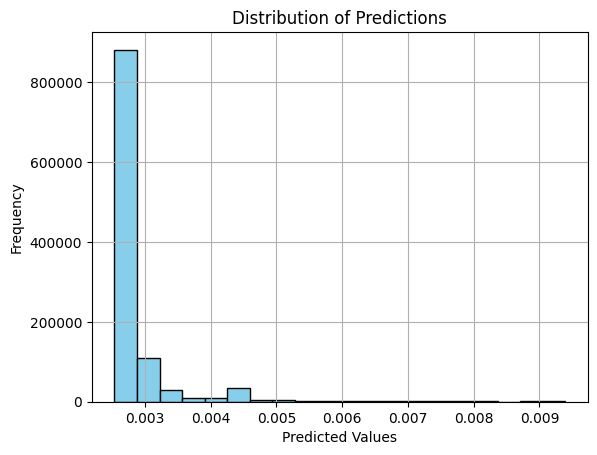

In [ ]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
#res = pd.read_csv('/content/data202402.csv', usecols=['UNINO', '換匯基因標籤', '換匯發送名單','TOTALNTAMOUNT', '跨售行為'])
#res['NN_lift_T=1'] = predictions_np
res['NN_lift_T=0'] = predictions_np
res['NN_lift'] = res['NN_lift_T=1']-res['NN_lift_T=0']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift_T=1,NN_lift_T=0,NN_lift
0,F1706395290,87.9483,0,0,0,0.002678,0.002569,0.000108
1,F1706405550,59.2382,0,0,0,0.002681,0.002571,0.000110
2,F1713360850,50.7072,0,0,0,0.002632,0.002535,0.000097
3,F1706408440,98.3747,0,0,0,0.002676,0.002570,0.000106
4,F1713368440,79.3979,0,0,0,0.002629,0.002536,0.000093
...,...,...,...,...,...,...,...,...
1103735,X2721994820,62.4777,0,0,0,0.002753,0.002626,0.000126
1103736,Y1221175610,45.0220,0,0,0,0.002562,0.002508,0.000055
1103737,W1223779390,78.4204,0,0,0,0.002927,0.002777,0.000150
1103738,X2725567450,83.9849,0,0,0,0.002599,0.002513,0.000085


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202402.csv')
#1103740 rows × 6 columns

## Value


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/data202401.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F2593340910,18,0,2.0,0,120.0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,F2593358270,19,0,2.0,0,0.0,1,2,0,3,...,0,0,0,0,0,1,0,0,0,0
2,F2593378680,19,0,2.0,0,50.0,1,0,0,6,...,0,0,0,0,0,1,0,0,0,0
3,F2593397620,19,0,2.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
4,F2598703540,17,0,2.0,0,0.0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092946,Z1222305990,50,0,1.0,0,600.0,1,3,0,1,...,0,0,0,1,0,0,0,1,0,1
1092947,Y2729592620,60,0,2.0,0,0.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
1092948,Z1222367980,47,0,1.0,0,420.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1092949,Z1222472300,30,0,1.0,0,550.0,1,1,0,1,...,0,0,1,0,0,1,0,0,0,0


In [83]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [84]:
#1. Minmax
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = numeric_cols.tolist()  # Convert Index to list

# Concatenate the lists of column names
numeric_cols += num_cols

# Assuming df is your DataFrame and columns_to_winsorize contains the column names you want to winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
unino = test['UNINO']
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(874360, 204) (218591, 204)


In [ ]:
train.iloc[:,149]

122069    0
700537    0
935544    0
733998    0
623164    0
         ..
110268    1
259178    0
131932    0
671155    0
121958    0
Name: 換匯發送名單, Length: 874360, dtype: int64

In [85]:
import torch
import torch.nn as nn

class MultiplyByTheta(nn.Module):
    def __init__(self, output_features):
        super(MultiplyByTheta, self).__init__()
        # Initialize theta as a parameter with 1.0 as its initial value
        # This assumes theta is a scalar. Adjust the size for vector outputs.
        self.theta = nn.Parameter(torch.ones(output_features))

    def forward(self, x):
        # Multiply input by theta
        return x * self.theta

class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        # Branch 1
        self.fc1_branch1 = nn.Linear(input_size, 128)
        self.bn1_branch1 = nn.BatchNorm1d(128)  # Add batch normalization
        self.relu1_branch1 = nn.ReLU()
        self.fc2_branch1 = nn.Linear(128, 1)

        # Branch 2
        self.fc1_branch2 = nn.Linear(input_size, 128)
        self.bn1_branch2 = nn.BatchNorm1d(128)  # Add batch normalization
        self.relu1_branch2 = nn.ReLU()
        self.fc2_branch2 = nn.Linear(128, 2)

        # Hidden layer
        self.fc_hidden = nn.Linear(3, 64)

        # Output layer
        self.fc_output = nn.Linear(64, 1)

        # MultiplyByTheta module
        self.multiply_theta = MultiplyByTheta(output_features=1)

    def forward(self, x):
        # Branch 1
        x_branch1 = self.relu1_branch1(self.bn1_branch1(self.fc1_branch1(x)))
        x_branch1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = self.relu1_branch2(self.bn1_branch2(self.fc1_branch2(x)))
        T1 = x[:, 149].unsqueeze(1)
        T2 = 1 - T1
        x_branch2 = torch.sigmoid(x_branch2)  # Apply sigmoid activation before element-wise multiplication
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2

        # Concatenate both branches
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Hidden layer
        x_hidden = torch.sigmoid(self.fc_hidden(x_concat))

        # Output layer
        output = torch.sigmoid(self.fc_output(x_hidden))

        # Multiply by theta
        output = self.multiply_theta(output)

        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_hidden): Linear(in_features=3, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=1, bias=True)
  (multiply_theta): MultiplyByTheta()
)


In [ ]:
# Check if GPU is available and move model to GPU
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(train['TOTALNTAMOUNT'].values, dtype=torch.float32)
X_val = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_val = torch.tensor(test['TOTALNTAMOUNT'].values, dtype=torch.float32)
# Define the hyperparameter search space
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0.001, 0.01, 0.1]
epochs = [10, 20, 30]

best_loss = float('inf')
best_hyperparameters = {}

# Iterate over all hyperparameter combinations
for lr in learning_rates:
    for weight_decay in weight_decays:
        for num_epochs in epochs:
            # Define the model
            input_size = 202  # Number of input features
            model = CustomNet(input_size)

            # Define the loss function: Mean Squared Error (MSE)
            criterion = nn.MSELoss()

            # Define the optimizer
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

            # Training loop
            for epoch in range(num_epochs):
                # Forward pass
                outputs = model(X_tensor)
                loss = criterion(outputs.squeeze(), y_tensor)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Evaluate the model on validation data
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs.squeeze(), y_val)

            # Update best hyperparameters if the current combination is better
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {"lr": lr, "weight_decay": weight_decay, "epochs": num_epochs}

# Train the final model using the best hyperparameters
input_size = 202  # Number of input features
model = CustomNet(input_size)
optimizer = optim.SGD(model.parameters(), lr=best_hyperparameters["lr"], weight_decay=best_hyperparameters["weight_decay"])
criterion = nn.MSELoss()

for epoch in range(best_hyperparameters["epochs"]):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs.squeeze(), y_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'lr': 0.1, 'weight_decay': 0.1, 'epochs': 10}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Assuming you have your input data X, target variable y, and theta values in tensors
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(train['TOTALNTAMOUNT'].values, dtype=torch.float32)

# Define the model
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(),  lr=0.1, weight_decay=0.1)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)  # Reduce LR by a factor of 0.1 every 1000 epochs

# Training loop
num_epochs = 50000
desired_loss = 0.005

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs.squeeze(), y_tensor)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

Epoch [1/50000], Loss: 0.2094
Epoch [2/50000], Loss: 0.1164
Epoch [3/50000], Loss: 0.0762
Epoch [4/50000], Loss: 0.0555
Epoch [5/50000], Loss: 0.0431
Epoch [6/50000], Loss: 0.0351
Epoch [7/50000], Loss: 0.0296
Epoch [8/50000], Loss: 0.0255
Epoch [9/50000], Loss: 0.0224
Epoch [10/50000], Loss: 0.0199
Epoch [11/50000], Loss: 0.0180
Epoch [12/50000], Loss: 0.0164
Epoch [13/50000], Loss: 0.0151
Epoch [14/50000], Loss: 0.0140
Epoch [15/50000], Loss: 0.0130
Epoch [16/50000], Loss: 0.0122
Epoch [17/50000], Loss: 0.0115
Epoch [18/50000], Loss: 0.0108
Epoch [19/50000], Loss: 0.0103
Epoch [20/50000], Loss: 0.0098
Epoch [21/50000], Loss: 0.0093
Epoch [22/50000], Loss: 0.0089
Epoch [23/50000], Loss: 0.0085
Epoch [24/50000], Loss: 0.0082
Epoch [25/50000], Loss: 0.0079
Epoch [26/50000], Loss: 0.0076
Epoch [27/50000], Loss: 0.0073
Epoch [28/50000], Loss: 0.0071
Epoch [29/50000], Loss: 0.0069
Epoch [30/50000], Loss: 0.0067
Epoch [31/50000], Loss: 0.0065
Epoch [32/50000], Loss: 0.0063
Epoch [33/50000],

In [ ]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/NN_value_202401.pth')

In [86]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_value_202401.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_hidden): Linear(in_features=3, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=1, bias=True)
  (multiply_theta): MultiplyByTheta()
)

In [136]:
test.iloc[:,149] = 1

In [137]:
# Prediction
# Assuming you have your test input data X_test in a tensor
test_data = torch.tensor(test.values, dtype=torch.float32)

X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['TOTALNTAMOUNT'].values)  # Last column as the target variable

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

Predictions: [[0.07046661]
 [0.07041794]
 [0.07047877]
 ...
 [0.07046396]
 [0.07052811]
 [0.07048407]]
Test Loss: 0.004946181550621986


In [138]:
# Define the min and max values for each feature
#min_val = df['TOTALNTAMOUNT'].min()
#max_val = df['TOTALNTAMOUNT'].max()

# Apply the inverse transform manually
predictions_np = (predictions_np * (max_val - min_val)) + min_val
predictions_np

array([[224746.19894624],
       [224590.97980261],
       [224784.97996926],
       ...,
       [224737.76312321],
       [224942.36153513],
       [224801.89914107]])

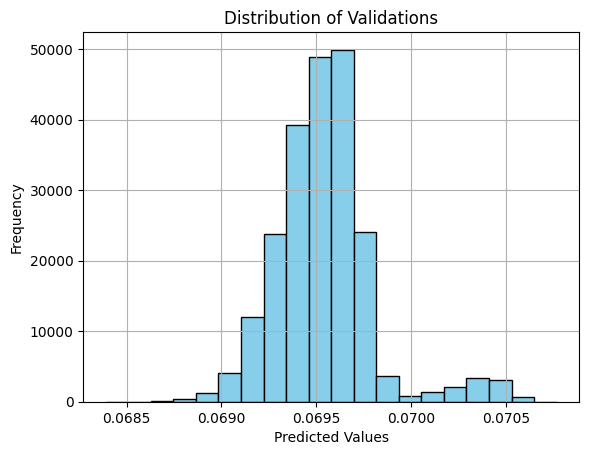

In [ ]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Validations')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [96]:
val = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202404_results.csv', index_col = 0)
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN
0,A2742220970,0,0.764158,0,0.0,0.008305,0.009161,0.000857
1,K2723921770,0,0.727208,0,0.0,0.008101,0.008910,0.000809
2,D1772966320,0,0.608271,0,0.0,0.008340,0.009221,0.000881
3,H2755330340,0,0.884345,0,0.0,0.008292,0.009141,0.000848
4,F2729554110,0,0.653208,0,0.0,0.008216,0.009066,0.000849
...,...,...,...,...,...,...,...,...
218586,U2729454260,0,0.653207,0,0.0,0.007545,0.008293,0.000748
218587,H1774062050,0,0.523841,0,0.0,0.007915,0.008725,0.000811
218588,F2716006190,0,0.793448,0,0.0,0.008318,0.009189,0.000871
218589,M2777104380,0,0.789480,0,0.0,0.008268,0.009096,0.000828


In [139]:
#val['Value_NN|T = 0'] = predictions_np
val['Value_NN|T = 1'] = predictions_np
val['Value_NN'] = val['Value_NN|T = 1'] - val['Value_NN|T = 0']
val

,UNINO,換匯發送名單,換匯基因標籤,跨售行為,TOTALNTAMOUNT,Lift_NN|T = 0,Lift_NN|T = 1,Lift_NN,Value_NN|T = 0,Value_NN|T = 1,Value_NN
0,A2742220970,0,0.764158,0,0.0,0.008305,0.009161,0.000857,222083.639334,224746.198946,2662.559612
1,K2723921770,0,0.727208,0,0.0,0.008101,0.008910,0.000809,221451.166473,224590.979803,3139.813329
2,D1772966320,0,0.608271,0,0.0,0.008340,0.009221,0.000881,222258.130175,224784.979969,2526.849794
3,H2755330340,0,0.884345,0,0.0,0.008292,0.009141,0.000848,222203.665650,224668.708189,2465.042539
4,F2729554110,0,0.653208,0,0.0,0.008216,0.009066,0.000849,221505.488421,224248.081419,2742.592998
...,...,...,...,...,...,...,...,...,...,...,...
218586,U2729454260,0,0.653207,0,0.0,0.007545,0.008293,0.000748,220799.659544,223131.297265,2331.637721
218587,H1774062050,0,0.523841,0,0.0,0.007915,0.008725,0.000811,221176.633900,223404.712982,2228.079082
218588,F2716006190,0,0.793448,0,0.0,0.008318,0.009189,0.000871,221527.968107,224737.763123,3209.795016
218589,M2777104380,0,0.789480,0,0.0,0.008268,0.009096,0.000828,222471.069358,224942.361535,2471.292177


In [150]:
val.to_csv('/content/drive/MyDrive/Sinopac/Results/Causalml_validation_202404_results.csv')

In [104]:
import pandas as pd
import numpy as np
def response_value_by_percentile(true_value, lift_value, treatment, group, bins=10):

    true_value, lift_value, treatment = np.array(true_value), np.array(lift_value), np.array(treatment)
    order = np.argsort(lift_value, kind='mergesort')[::-1]

    trmnt_flag = 1 if group == 'treatment' else 0


    y_true_bin = np.array_split(true_value[order], bins)
    trmnt_bin = np.array_split(treatment[order], bins)
    group_size = np.array([len(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    response_value = np.array([np.mean(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    variance = np.array([np.var(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
    #variance = np.multiply(response_value, np.divide((1 - response_value), group_size))

    return response_value, variance, group_size


def uplift_value_by_percentile(true_value, lift_value, treatment, bins=10, string_percentiles=True):
    true_value, lift_value, treatment = np.array(true_value), np.array(lift_value), np.array(treatment)

    response_value_trmnt, variance_trmnt, n_trmnt = response_value_by_percentile(
        true_value, lift_value, treatment, group='treatment', bins=bins)

    response_value_ctrl, variance_ctrl, n_ctrl = response_value_by_percentile(
        true_value, lift_value, treatment, group='control', bins=bins)

    uplift_scores = response_value_trmnt - response_value_ctrl
    uplift_variance = variance_trmnt + variance_ctrl

    percentiles = [round(p * 100 / bins) for p in range(1, bins + 1)]

    if string_percentiles:
        percentiles = [f"0-{percentiles[0]}"] + \
            [f"{percentiles[i]}-{percentiles[i + 1]}" for i in range(len(percentiles) - 1)]


    df = pd.DataFrame({
        'percentile': percentiles,
        'n_treatment': n_trmnt,
        'n_control': n_ctrl,
        'response_value_treatment': response_value_trmnt,
        'response_value_control': response_value_ctrl,
        'uplift': uplift_scores
    })

    std_treatment = np.sqrt(variance_trmnt)
    std_control = np.sqrt(variance_ctrl)
    std_uplift = np.sqrt(uplift_variance)

    df.loc[:, 'std_treatment'] = std_treatment
    df.loc[:, 'std_control'] = std_control
    df.loc[:, 'std_uplift'] = std_uplift

    df = df \
        .set_index('percentile', drop=True, inplace=False) \
        .astype({'n_treatment': 'int32', 'n_control': 'int32'})

    return df

In [149]:
val['TOTALNTAMOUNT'] = df['TOTALNTAMOUNT']
val['TOTALNTAMOUNT'].describe()

count    2.185910e+05
mean     2.612291e+02
std      1.392776e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.189400e+06
Name: TOTALNTAMOUNT, dtype: float64

In [151]:
uplift_value_by_percentile(
        val["TOTALNTAMOUNT"],
        val['Value_NN'],
        val["換匯發送名單"],
        bins=10
    )

,n_treatment,n_control,response_value_treatment,response_value_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,150,21710,200.000000,188.264947,11.735053,2441.311123,11220.062549,11482.586973
10-20,413,21446,0.000000,402.089947,-402.089947,0.000000,26070.445571,26070.445571
20-30,642,21217,99.482866,239.520243,-140.037377,1810.363095,10524.626145,10679.193323
30-40,830,21029,1079.268675,358.415617,720.853058,19498.696982,15166.291005,24702.541708
40-50,992,20867,95.446573,218.099248,-122.652675,2155.797039,14523.673571,14682.797924
50-60,1530,20329,631.319608,176.438241,454.881367,17335.791170,7037.757934,18709.882208
60-70,1907,19952,294.910330,249.490377,45.419953,8341.927464,9520.538529,12658.136028
70-80,2028,19831,118.196252,295.721446,-177.525194,3048.426119,12915.118016,13270.010368
80-90,1967,19892,61.611591,243.238186,-181.626595,1373.585944,15033.673318,15096.293313


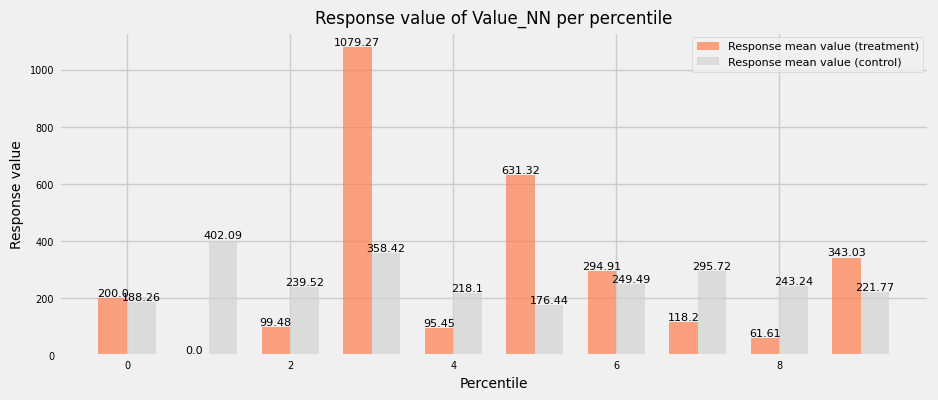

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklift.metrics import uplift_by_percentile

def plot_uplift_value_by_percentile(df, metric_column, bins=10):

    # Fill NaN values in the metric_column with a specific value (e.g., 0)
    df[metric_column].fillna(0, inplace=True)

    uplift_by_perc_df = uplift_value_by_percentile(
        df["TOTALNTAMOUNT"],
        df[metric_column],
        df["換匯發送名單"],
        bins=10
    )
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 4))

    # Plot the second graph (Response Rates for Treatment and Control)
    bar_width = 0.35
    index = np.arange(len(uplift_by_perc_df.index))

    bars2_treatment = ax2.bar(
        index - bar_width/2,
        uplift_by_perc_df.response_value_treatment,
        bar_width,
        label="Response mean value (treatment)",
        color='coral',
        #yerr=uplift_by_perc_df.std_treatment * 2,
        alpha=0.7
    )

    bars2_control = ax2.bar(
        index + bar_width/2,
        uplift_by_perc_df.response_value_control,
        bar_width,
        label="Response mean value (control)",
        color='lightgrey',
        #yerr=uplift_by_perc_df.std_control * 2,
        alpha=0.7
    )

    ax2.set_title(f'Response value of {metric_column} per percentile', fontsize=12)
    ax2.set_xlabel('Percentile', fontsize=10)
    ax2.set_ylabel('Response value', fontsize=10)
    ax2.legend(fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Treatment)
    for bar, label in zip(bars2_treatment, uplift_by_perc_df.response_value_treatment):
        yval = bar.get_height()

        # Check for NaN values before rounding
        if not math.isnan(label):
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.0001, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.00001, 'NaN', ha='center', va='bottom', fontsize=8)

    # Adding smaller text labels on each bar for Response Rates (Control)
    for bar, label in zip(bars2_control, uplift_by_perc_df.response_value_control):
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{round(label, 2)}', ha='center', va='bottom', fontsize=8)

    # Set smaller font size for tick labels
    ax2.tick_params(axis='both', which='major', labelsize=7)

    # Ensure that the y-axis starts from 0
    ax2.set_ylim(bottom=0)

    plt.show()

# Usage example for 'Uplift_mean' column
plot_uplift_value_by_percentile(val, 'Value_NN')

In [161]:
from causalml.metrics import plot_gain, get_cumgain
T = val
T =T[['換匯發送名單', 'TOTALNTAMOUNT',	'Value_NN']]
#T['Value_NN'] = T['Value_NN']/(max_val - min_val)
cumgain = get_cumgain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42)
cumgain

,Value_NN,Random
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
218587,0.999816,0.999903
218588,0.999862,0.999949
218589,0.999908,0.999995
218590,0.999954,0.999954


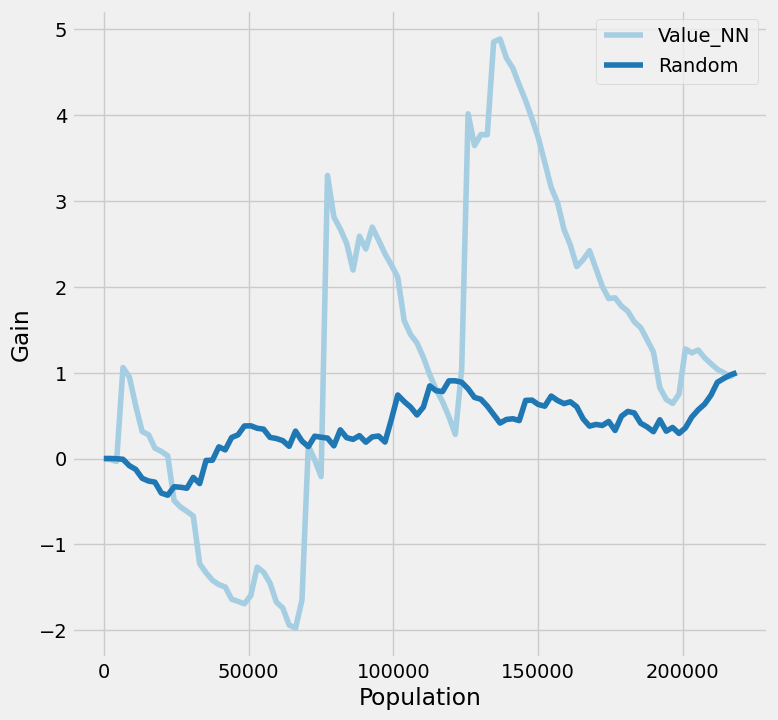

In [162]:
plot_gain(T, outcome_col='TOTALNTAMOUNT', treatment_col='換匯發送名單', normalize=True, random_seed=42)

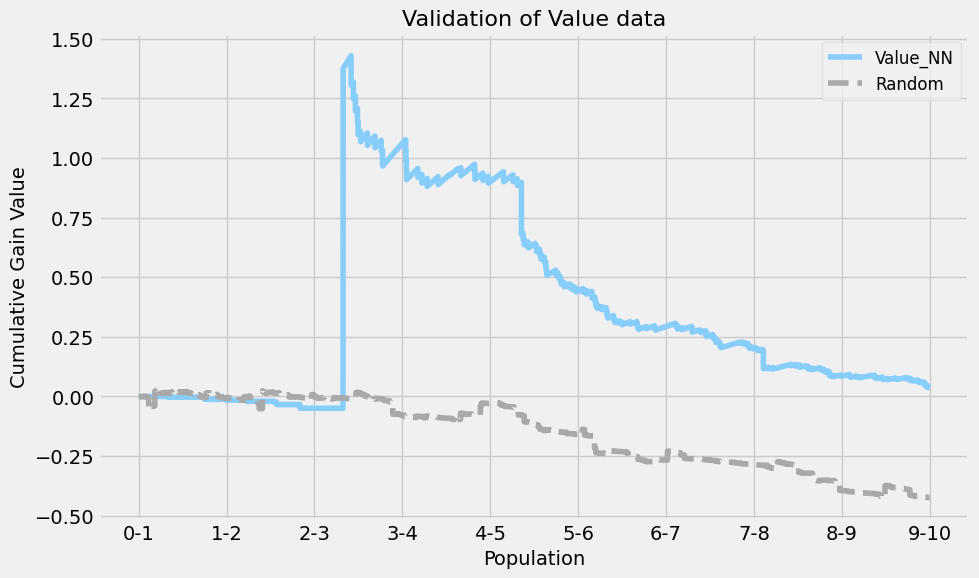

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have already imported pandas as pd and have the necessary dataframes

#df = pd.concat([cumgain, cumgain_1['Gi']], axis=1)
#df = cumgain
df = cumgain[:len(cumgain)//10]
x = df.index

# Define the ranges for the x-axis labels
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
#ranges = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Resample x to have 11 evenly spaced points
x_resampled = np.linspace(0, len(x) - 1, 10, dtype=int)

# Plotting the lines with customizations
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(x, df['Value_NN'], label='Value_NN', color='lightskyblue')  # Set color and line width
plt.plot(x, df['Random'], label='Random', color='darkgray', linestyle='--')  # Set color and marker

# Adding labels, title, and legend with custom text size
plt.xlabel('Population', fontsize=14)  # Set x-axis label with custom text size
plt.ylabel('Cumulative Gain Value', fontsize=14)  # Set y-axis label with custom text size
plt.title('Validation of Value data', fontsize=16)  # Set title with custom text size
plt.legend(fontsize=12)  # Set legend with custom text size

# Setting x-axis ticks and labels
plt.xticks(x_resampled, ranges)

# Displaying the plot
plt.show()

###Predictions

In [ ]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202402.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202402.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F1706395290,37,0,1.0,0,500.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1,F1706405550,37,0,1.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
2,F1713360850,41,0,1.0,0,0.0,1,3,0,3,...,0,0,0,0,0,1,0,0,0,0
3,F1706408440,37,0,1.0,0,27.0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,1
4,F1713368440,41,0,1.0,0,340.0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103735,X2721994820,33,0,2.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1103736,Y1221175610,71,0,1.0,0,0.0,1,0,0,8,...,0,0,0,1,0,0,0,0,0,0
1103737,W1223779390,27,0,1.0,0,300.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1103738,X2725567450,45,0,2.0,0,700.0,1,1,0,1,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [ ]:
#1. Minmax
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols = numeric_cols.tolist()  # Convert Index to list

# Concatenate the lists of column names
numeric_cols += num_cols

# Assuming df is your DataFrame and columns_to_winsorize contains the column names you want to winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=(0.05, 0.05))

# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.drop(['UNINO'], axis = 1, inplace = True)
print(df.shape)

(1103740, 204)


In [ ]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_value_202401.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch1): ReLU()
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=128, bias=True)
  (bn1_branch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_branch2): ReLU()
  (fc2_branch2): Linear(in_features=128, out_features=2, bias=True)
  (fc_hidden): Linear(in_features=3, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=1, bias=True)
  (multiply_theta): MultiplyByTheta()
)

In [ ]:
#T1 = pi01
#Treatment = 1
df.iloc[:, 149] = 0
df.iloc[:, 149]

0          0
1          0
2          0
3          0
4          0
          ..
1103735    0
1103736    0
1103737    0
1103738    0
1103739    0
Name: 換匯發送名單, Length: 1103740, dtype: int64

In [ ]:
#202402

X_pred = torch.tensor(df.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_pred = torch.tensor(df['TOTALNTAMOUNT'].values)  # Last column as the target variable

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_pred.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_pred.float())
print("Test Loss:", loss_test.item())

Predictions: [[0.06955923]
 [0.0696911 ]
 [0.06969684]
 ...
 [0.06956025]
 [0.06972637]
 [0.06945028]]
Test Loss: 0.00483010895550251


In [ ]:
# Define the min and max values for each feature
#min_val = df['TOTALNTAMOUNT'].min()
#max_val = df['TOTALNTAMOUNT'].max()

# Apply the inverse transform manually
predictions_np = (predictions_np * (max_val - min_val)) + min_val

In [ ]:
import numpy as np

# Assuming predictions_np is your NumPy array
mean = np.mean(predictions_np)
median = np.median(predictions_np)
std_dev = np.std(predictions_np)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 347493.5365901088
Median: 347590.4564475417
Standard Deviation: 932.2542967516615


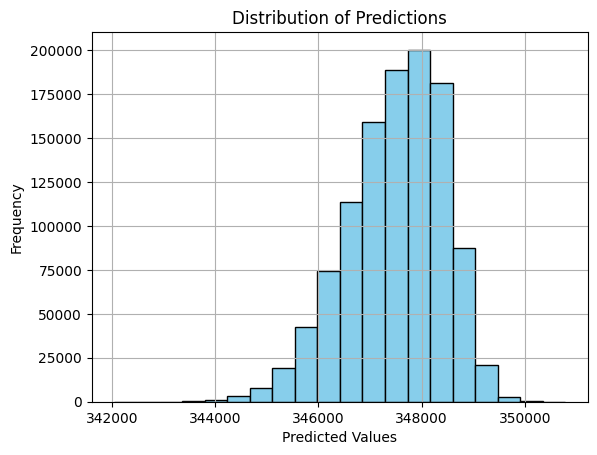

In [ ]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
res = pd.read_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202402.csv', index_col = 0)
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift_T=1,NN_lift_T=0,NN_lift,NN_value_T=1,NN_value_T=0,NN_value
0,F1706395290,87.94830,0,0,0,0.00268,0.00257,0.00011,352559.43292,347796.01788,4763.41504
1,F1706405550,59.23820,0,0,0,0.00268,0.00257,0.00011,352646.45567,348455.35675,4191.09892
2,F1713360850,50.70720,0,0,0,0.00263,0.00254,0.00010,351937.12343,348484.04147,3453.08196
3,F1706408440,98.37470,0,0,0,0.00268,0.00257,0.00011,351584.97188,348116.54173,3468.43015
4,F1713368440,79.39790,0,0,0,0.00263,0.00254,0.00009,352533.80294,346832.36018,5701.44276
...,...,...,...,...,...,...,...,...,...,...,...
1103735,X2721994820,62.47770,0,0,0,0.00275,0.00263,0.00013,352510.51988,348941.13441,3569.38547
1103736,Y1221175610,45.02200,0,0,0,0.00256,0.00251,0.00005,349182.57038,346032.01913,3150.55125
1103737,W1223779390,78.42040,0,0,0,0.00293,0.00278,0.00015,353071.51112,347801.12153,5270.38959
1103738,X2725567450,83.98490,0,0,0,0.00260,0.00251,0.00009,352167.30902,348631.71192,3535.59710


In [ ]:
import pandas as pd
#res = pd.read_csv('/content/data202402.csv', usecols=['UNINO', '換匯基因標籤', '換匯發送名單','TOTALNTAMOUNT', '跨售行為'])
#res['NN_value_T=1'] = predictions_np
res['NN_value_T=0'] = predictions_np
res['NN_value'] = res['NN_value_T=1']-res['NN_value_T=0']
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift_T=1,NN_lift_T=0,NN_lift,NN_value_T=1,NN_value_T=0,NN_value
0,F1706395290,87.9483,0,0,0,0.002678,0.002569,0.000108,352559.432925,347796.017884,4763.415041
1,F1706405550,59.2382,0,0,0,0.002681,0.002571,0.000110,352646.455671,348455.356750,4191.098921
2,F1713360850,50.7072,0,0,0,0.002632,0.002535,0.000097,351937.123429,348484.041474,3453.081955
3,F1706408440,98.3747,0,0,0,0.002676,0.002570,0.000106,351584.971878,348116.541733,3468.430145
4,F1713368440,79.3979,0,0,0,0.002629,0.002536,0.000093,352533.802938,346832.360175,5701.442763
...,...,...,...,...,...,...,...,...,...,...,...
1103735,X2721994820,62.4777,0,0,0,0.002753,0.002626,0.000126,352510.519883,348941.134411,3569.385472
1103736,Y1221175610,45.0220,0,0,0,0.002562,0.002508,0.000055,349182.570378,346032.019127,3150.551251
1103737,W1223779390,78.4204,0,0,0,0.002927,0.002777,0.000150,353071.511124,347801.121530,5270.389594
1103738,X2725567450,83.9849,0,0,0,0.002599,0.002513,0.000085,352167.309025,348631.711922,3535.597102


In [ ]:
# Import pandas
import pandas as pd

# Set the display option to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)
res.iloc[:,5:].describe()

,NN_lift_T=1,NN_lift_T=0,NN_lift,NN_value_T=1,NN_value_T=0,NN_value
count,1103740.00000,1103740.00000,1103740.00000,1103740.00000,1103740.00000,1103740.00000
mean,0.00286,0.00275,0.00011,351646.59324,347493.53659,4153.05665
std,0.00073,0.00066,0.00009,969.34998,932.25472,665.52085
min,0.00253,0.00248,-0.00000,345747.51882,342052.74013,2410.29911
25%,0.00257,0.00250,0.00007,351270.29673,346894.83327,3641.69333
50%,0.00262,0.00253,0.00009,351895.95899,347590.45645,4030.16644
75%,0.00280,0.00267,0.00013,352293.70807,348199.28040,4615.55833
max,0.00939,0.00859,0.00087,354601.11471,350779.89971,7043.77608


In [ ]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202402.csv')
#1103740 rows × 6 columns

In [ ]:
output = res.drop(['UNINO'], axis = 1)
output.to_csv('/content/output.csv')